In [3]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_score
from sklearn.pipeline import Pipeline

%precision 4


'%.4f'

# Clustering

## Curse of dimensionality

### Sparsity

As the number of dimensions increases, data becomes increasingly sparse: the probability of finding points away from the boundaries approaches zero. Consider uniformly distributed random variables on the [0, 1] interval. If we define "internal points" as those not within 2% of the extremes (i.e., points in [0.02, 0.98]):

- In 1 dimension: The probability of sampling an internal point is 0.98 - 0.02 = 0.96 (96%)
- In 2 dimensions: The probability becomes 0.96² = 0.92 (92%)
- In 3 dimensions: The probability further reduces to 0.96³ = 0.88 (88%)

This pattern continues multiplicatively with each additional dimension. By induction, in a 100-dimensional space, the probability of sampling an internal point falls to 0.96¹⁰⁰ ≈ 0.017 (less than 2%).
This means that in high-dimensional spaces, almost all points lie near the boundaries of the space—a counterintuitive property that makes statistical sampling, clustering, and distance-based algorithms increasingly challenging as dimensionality grows.

### Distance metrics in high-dimensional spaces gets useless

As the dimensionality increases, the average distance from a random point to other points in the dataset obviously grows. However, somewhat counterintuitively, the ratio between the distance to the nearest point and the distance to the farthest point converges toward 1. This means that in very high dimensions, all points become almost equidistant from each other. This concentration of distances undermines the fundamental assumption of many clustering algorithms that nearby points should be more similar than distant ones.

Let's run a simulation to see how this works. (I did not use prng here as reproducibility is not an issue here.)

In [11]:
def generate_random_dataset(num_points, num_dimensions):
    # Generate random points uniformly distributed in [0, 1]^n
    return np.random.rand(num_points, num_dimensions)

def calculate_distances(dataset, query_point):
    # calculate Euclidean distances in an efficient way
    return np.linalg.norm(dataset - query_point, axis=1)

def run_experiment(dimensions, num_points=100):
    min_distances = []
    max_distances = []
    
    for dim in dimensions:
        # Generate a random dataset and a query point
        dataset = generate_random_dataset(num_points, dim)
        
        # define a query point
        query_point = np.repeat(0.5, dim)
        
        # Calculate distances from the query point
        distances = calculate_distances(dataset, query_point)
        
        # Record the min and max distances
        min_distances.append(np.min(distances))
        max_distances.append(np.max(distances))

    return {'min_distances': min_distances, 'max_distances': max_distances}
    

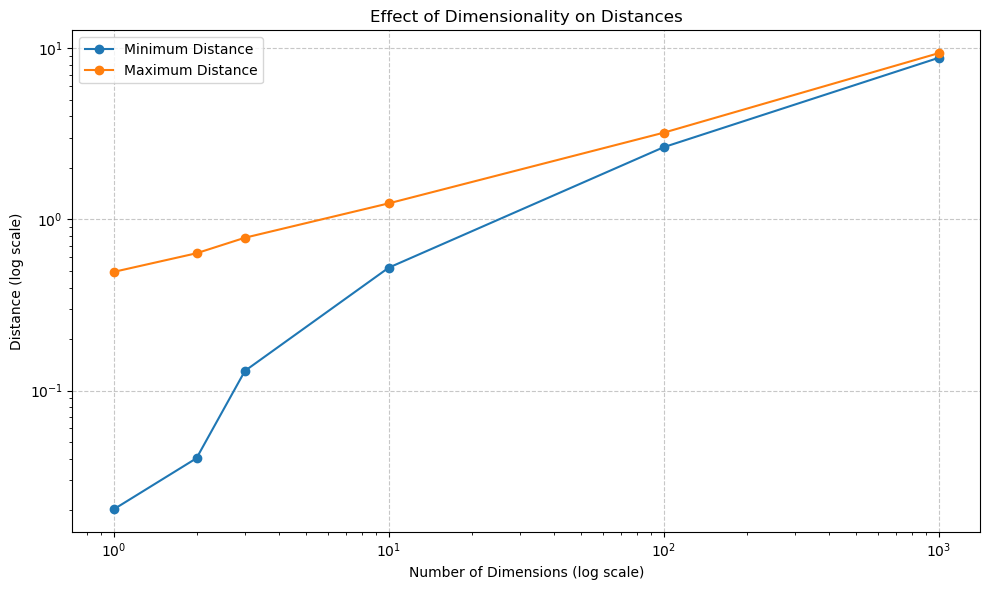

In [12]:
# Run the experiment
dimensions = [1, 2, 3, 10, 100, 1000]
results = run_experiment(dimensions=dimensions)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dimensions, results['min_distances'], label='Minimum Distance', marker='o')
plt.plot(dimensions, results['max_distances'], label='Maximum Distance', marker='o')
plt.xlabel("Number of Dimensions (log scale)")
plt.ylabel("Distance (log scale)")
plt.title("Effect of Dimensionality on Distances")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xscale('log')  # Use log scale for better visualization
plt.yscale('log')
plt.tight_layout()


## K-Means on the wine dataset

Let's use the wine dataset from the previous class.

Recall the algorithm: [StatQuest video](https://www.youtube.com/watch?v=4b5d3muPQmA&ab_channel=StatQuestwithJoshStarmer)

In [34]:
prng = np.random.RandomState(20250310)

X, y = load_wine(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=prng
)

### K-Means on full data

In [35]:
# KMeans
kmeans = KMeans(n_clusters=3, random_state=prng) # define the model
kmeans.fit(X_train) # fit the model

KMeans(n_clusters=3, random_state=RandomState(MT19937) at 0x176FBAA40)

In [36]:
kmeans.cluster_centers_.shape

(3, 13)

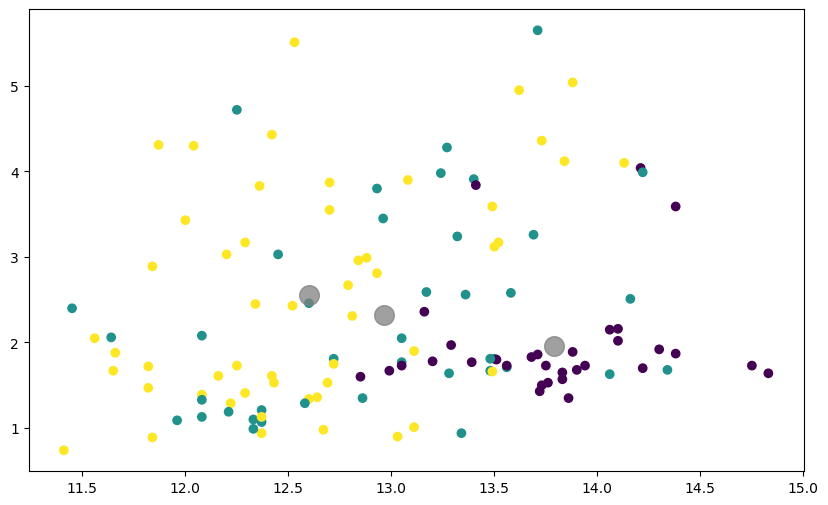

In [37]:
# plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='gray', s=200, alpha=0.75)

### K-Means with PCA (after scaling)

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

pca = PCA(n_components=2)
scaled_X_train_pca = pca.fit_transform(X_train_scaled)

kmeans_pc12 = KMeans(n_clusters=3, random_state=prng).fit(scaled_X_train_pca)

**TODO**:
- Run K-Means algorithm on the first two Principal Components of the dataset
- Name the transformed dataset as `scaled_X_train_pca` and the K-Means model as `kmeans_pc12`
- Run the plotting command in the cell below
- If you worked well, you should get a chart with three nicely separated clusters

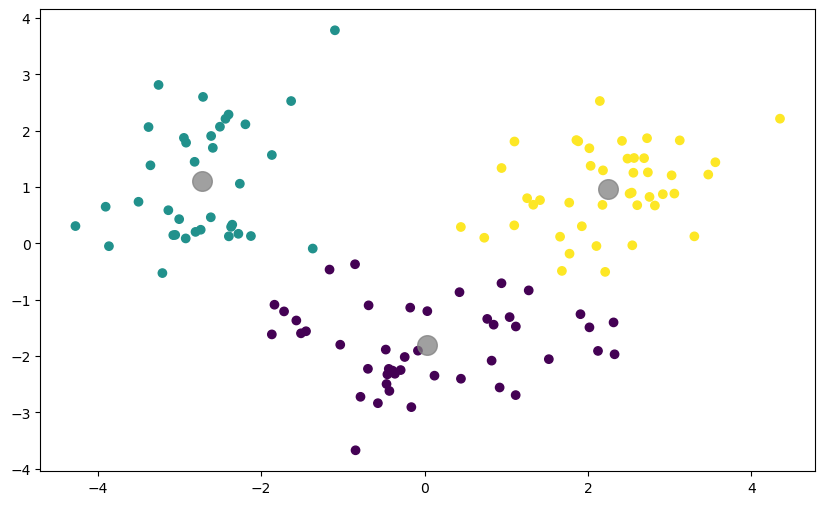

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(scaled_X_train_pca[:, 0], scaled_X_train_pca[:, 1], c=kmeans_pc12.labels_, cmap='viridis')
plt.scatter(kmeans_pc12.cluster_centers_[:, 0], kmeans_pc12.cluster_centers_[:, 1], c='gray', s=200, alpha=0.75)

#### Compare the clusters to the true lables

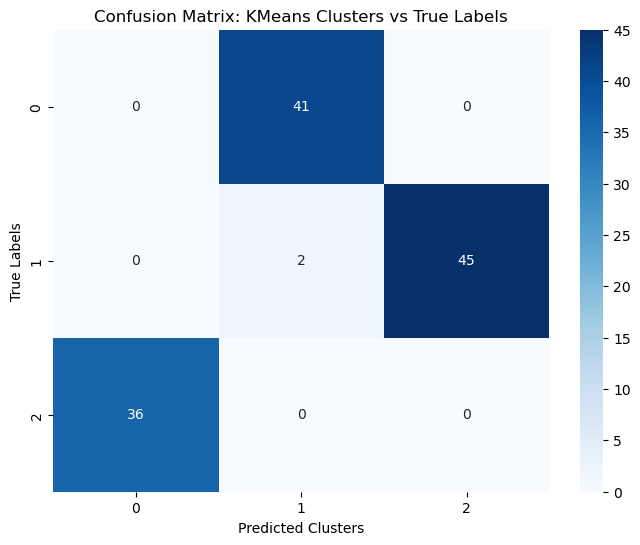

In [27]:
# Create confusion matrix between kmeans labels and true labels
def plotConfusionMatrix(true_y, kmeans_labels):
    conf_matrix = confusion_matrix(true_y, kmeans_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix: KMeans Clusters vs True Labels")
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Labels")

plotConfusionMatrix(y_train, kmeans_pc12.labels_)

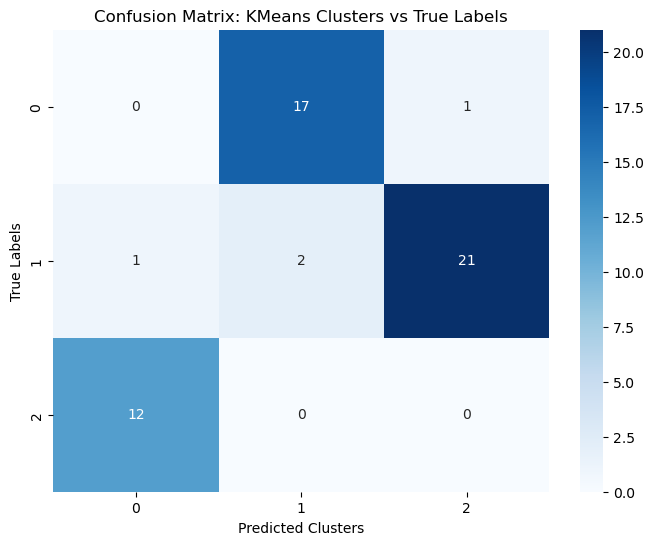

In [28]:
plotConfusionMatrix(y_test, kmeans_pc12.predict(pca.transform(scaler.transform(X_test))))

#### Technical detour: Pipeline

When evaluating our model on a new dataset, we must apply the same transformations used on the training set (e.g., scaling, projecting onto PC1 & PC2). Doing this manually can quickly become tedious and error-prone. Fortunately, sklearn provides a convenient solution: Pipeline.

A Pipeline streamlines preprocessing by defining a sequence of transformations once and applying them consistently to any dataset. It consists of a list of steps, where each step is a two-element tuple: a name (which you choose) and the corresponding operation. The steps are executed sequentially, ensuring a structured and reproducible workflow.

In [44]:
pipeline_pc12 = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=2)),
    ('kmeans', KMeans(n_clusters=3, random_state=prng))
])
pipeline_pc12

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('kmeans',
                 KMeans(n_clusters=3,
                        random_state=RandomState(MT19937) at 0x176FBAA40))])

In [45]:
pipeline_pc12.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('kmeans',
                 KMeans(n_clusters=3,
                        random_state=RandomState(MT19937) at 0x176FBAA40))])

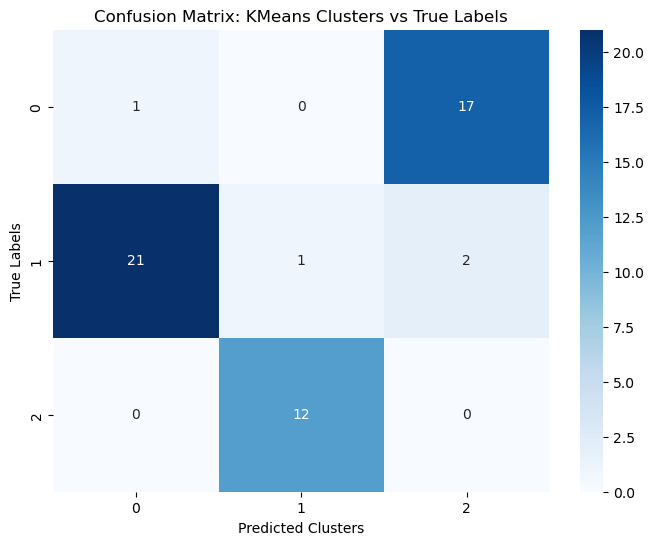

In [46]:
plotConfusionMatrix(y_test, pipeline_pc12.predict(X_test))

#### Evaluate the segments on the test data

In [47]:
# Calculate accuracy
# Create mapping dictionary to relabel clusters for consolidation
label_mapping = {0: 1, 1: 2, 2: 0}

# Apply mapping to kmeans labels
def relabel_clusters(labels, mapping):
    return np.array([mapping[label] for label in labels])

# Compute accuracy
def cluster_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

accuracy = cluster_accuracy(y_train, relabel_clusters(kmeans_pc12.labels_, label_mapping))
print(f"Clustering Accuracy: {accuracy:.2%}")


Clustering Accuracy: 98.39%


*Question:* What is the difference between this exercise and a standard classification problem?

<details>
<summary>Answer</summary>

In a standard classification problem, we have a dataset with both features and labels. We use the features to predict the labels, which is why it's called supervised learning—the algorithm is 'supervised' by known correct answers during training.

In this clustering exercise, we use only the features to group the data into different clusters without using their actual labels—making it an unsupervised learning approach. The algorithm must discover patterns and structure in the data without guidance from known outcomes.

The key difference is that in classification, we explicitly train a model to map features to known labels, while in clustering, we seek to identify natural groupings based solely on feature similarity. Only after clustering do we examine how well these discovered groups align with the known wine classes.

This exercise illustrates the power of unsupervised learning for segmentation and pattern discovery in scenarios where labeled data may be unavailable, expensive to obtain, or when we want to discover novel patterns that might not align with predetermined categories.

</details>

### What if we don't know the number of clusters?

We can use two clustering metrics to help us determine the optimal number of clusters:

1. **Inertia** is a measure of how internally coherent clusters are. Specifically, it's the sum of squared distances between each point and its assigned cluster centroid.

    - Lower inertia values indicate more compact, well-defined clusters
    - Inertia always decreases as the number of clusters increases -- we need to use the 'elbow' method to find the optimal number of clusters
    - It's sensitive to scale and doesn't handle differently sized clusters well

2. **Silhouette Score** measures how similar points are to their own cluster compared to other clusters. It's a more sophisticated metric that accounts for both the compactness of clusters and their separation from other clusters.

    - Higher silhouette scores indicate better-defined clusters
    - Silhouette score ranges from -1 to 1, where 1 is the best possible score
    - It's less sensitive to scale and can handle differently sized clusters better

In [48]:
kmeans_pc12.inertia_  # same as pipeline_pc12['kmeans'].inertia_

184.1369

In [49]:
data_used_for_clustering = pipeline_pc12['pca'].transform(pipeline_pc12['scaler'].transform(X_train))
data_used_for_clustering = pipeline_pc12[:-1].transform(X_train)  # run the pipline up until the last step

silhouette_score(data_used_for_clustering, pipeline_pc12['kmeans'].labels_)

0.5613

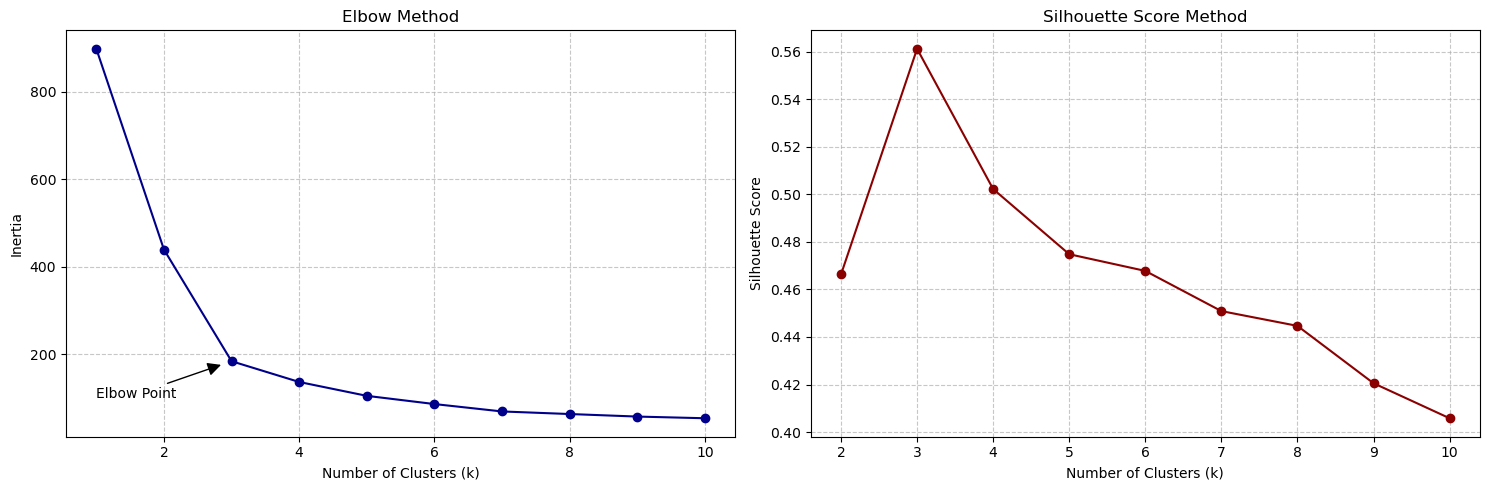

In [50]:
# Try different numbers of clusters and calculate inertia & silhouette score
inertias = []
silhouette_scores = []
n_clusters_range = range(1, 11)

for n_clusters in n_clusters_range:
    # Create and fit pipeline with different number of clusters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=prng))
    ])
    
    pipeline.fit(X_train)
    
    # Get inertia
    inertias.append(pipeline['kmeans'].inertia_)
    
    # Calculate silhouette score for n_clusters > 1
    if n_clusters > 1:
        silhouette_scores.append(silhouette_score(pipeline[:-1].transform(X_train), pipeline['kmeans'].labels_))

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Inertia plot
ax1.plot(n_clusters_range, inertias, marker='o', color='darkblue')
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia")
ax1.set_title("Elbow Method")
ax1.grid(True, linestyle='--', alpha=0.7)

ax1.annotate(
    "Elbow Point", 
    xy=(3, inertias[2]), xytext=(1, 100),
    arrowprops=dict(arrowstyle='-|>', shrinkA=2, shrinkB=8, facecolor='black', mutation_scale=20), fontsize=10
)

# Silhouette score plot
ax2.plot(list(n_clusters_range)[1:], silhouette_scores, marker='o', color='darkred')
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score Method")
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


So far, we created clusters based on the first two principal components only. However, we can use all the data without applying PCA. The predicted clusters nicely match with the previous results.

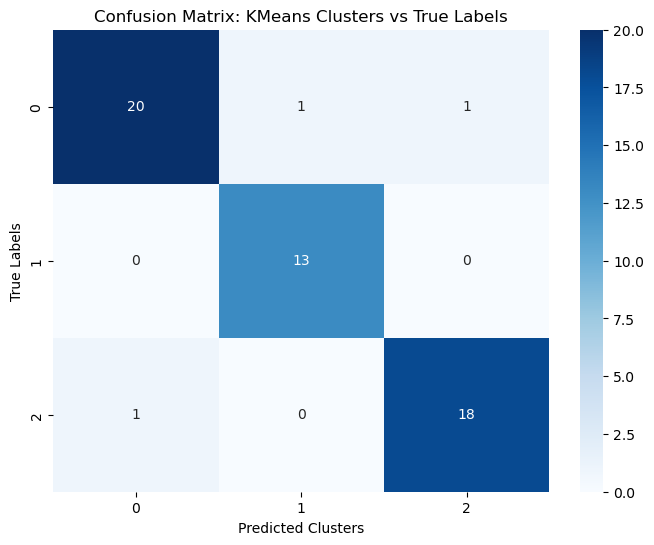

In [51]:
# Run KMeans on all the data for 3 clusters
pipeline_without_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=prng))
])
pipeline_without_pca.fit(X_train)

# Compare predictions
plotConfusionMatrix(pipeline_pc12.predict(X_test), pipeline_without_pca.predict(X_test))

In [53]:
# What would bring us extreme Silhouette scores?

(124, 13)

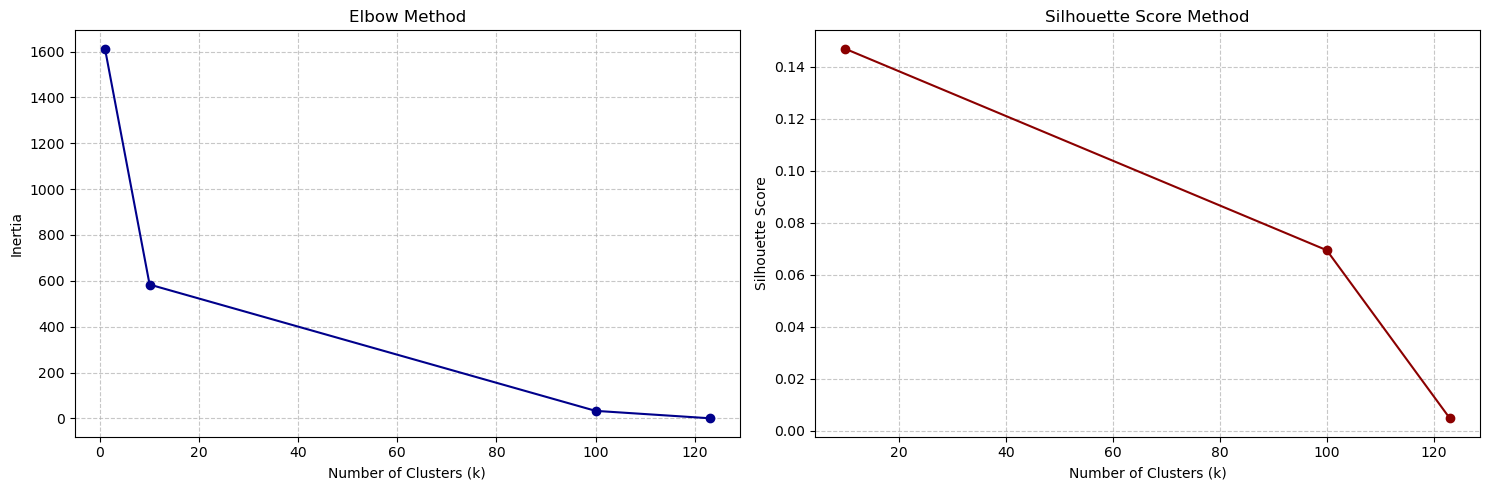

In [55]:
# Try different numbers of clusters and calculate inertia & silhouette score
inertias = []
silhouette_scores = []
n_clusters_range = [1, 10, 100, 123]

for n_clusters in n_clusters_range:
    # Create and fit pipeline with different number of clusters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=prng))
    ])
    
    pipeline.fit(X_train)
    
    # Get inertia
    inertias.append(pipeline['kmeans'].inertia_)
    
    # Calculate silhouette score for n_clusters > 1
    if n_clusters > 1:
        silhouette_scores.append(silhouette_score(pipeline[:-1].transform(X_train), pipeline['kmeans'].labels_))

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Inertia plot
ax1.plot(n_clusters_range, inertias, marker='o', color='darkblue')
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia")
ax1.set_title("Elbow Method")
ax1.grid(True, linestyle='--', alpha=0.7)

# Silhouette score plot
ax2.plot(list(n_clusters_range)[1:], silhouette_scores, marker='o', color='darkred')
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score Method")
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Create and fit pipeline with 3 clusters on training data
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=prng))
])

pipeline.fit(X_train)

# Get predictions on test data
y_pred = pipeline.predict(X_test)

# Create figure with subplots for each feature
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()  # Flatten axes array for easier indexing



# Plot distribution for each feature
for i, feature in enumerate(X_test.columns):
    for cluster in range(3):
        sns.kdeplot(
            data=X_test[feature][y_pred == cluster],
            ax=axes[i],
            label=f"Cluster {cluster}"
        )
    axes[i].set_title(f"{feature}")
    axes[i].set_xlabel("")

# Remove any empty subplots
for i in range(13, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## Kmeans on a non-spherical dataset

Text(0, 0.5, 'Feature 2')

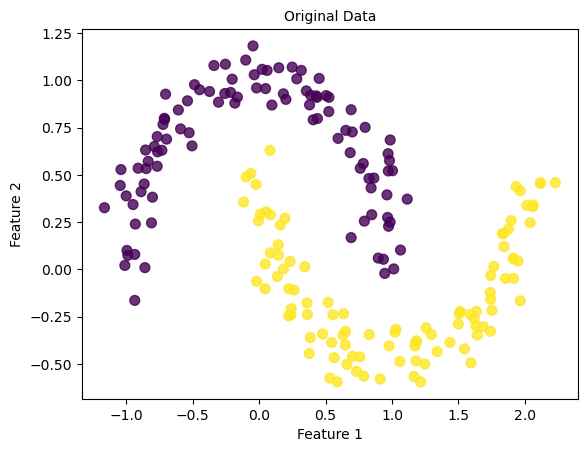

In [71]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=200, noise=0.1, random_state=prng)

plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons, cmap='viridis', s=50, alpha=0.8)
plt.title(f"Original Data", fontsize=10)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

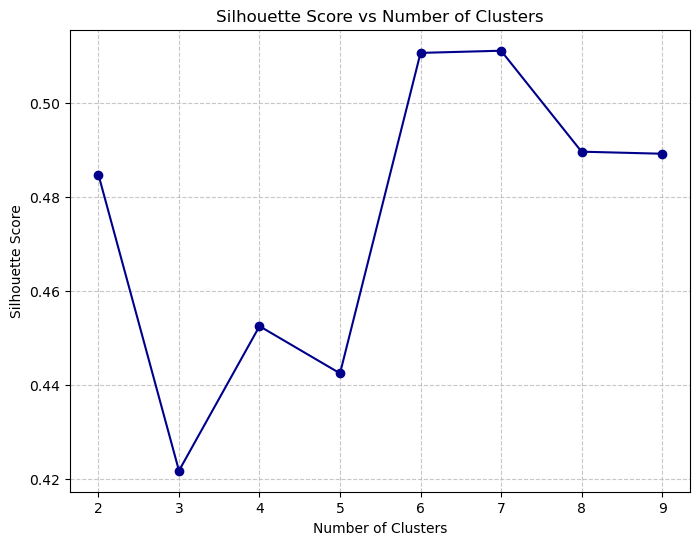

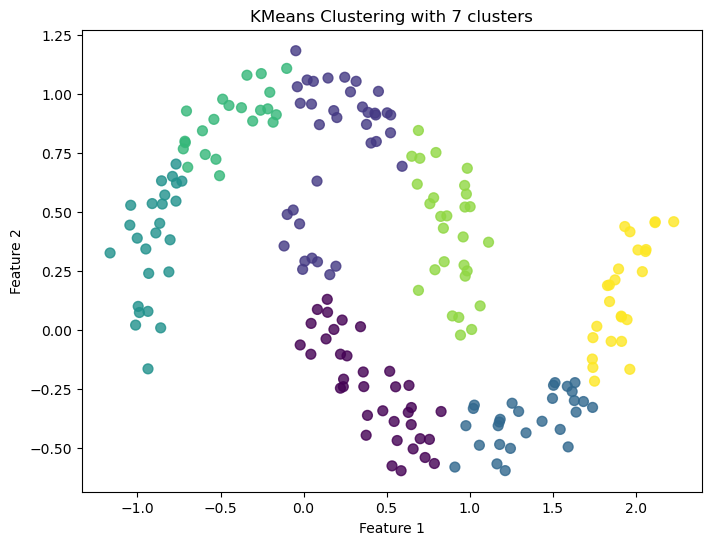

In [72]:
# Try different numbers of clusters and calculate silhouette scores
n_clusters_range = range(2, 10)
silhouette_scores = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=prng)
    cluster_labels = kmeans.fit_predict(X_moons)
    silhouette_avg = silhouette_score(X_moons, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(n_clusters_range, silhouette_scores, marker='o', color='darkblue')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Get optimal number of clusters
optimal_clusters = n_clusters_range[np.argmax(silhouette_scores)]

# Fit KMeans with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=prng)
cluster_labels = kmeans.fit_predict(X_moons)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.8)
plt.title(f'KMeans Clustering with {optimal_clusters} clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


## Another clustering algorithm: DBSCAN

Recall the algorithm: [StatQuest video](https://www.youtube.com/watch?v=RDZUdRSDOok&ab_channel=StatQuestwithJoshStarmer)

In [73]:
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_moons)

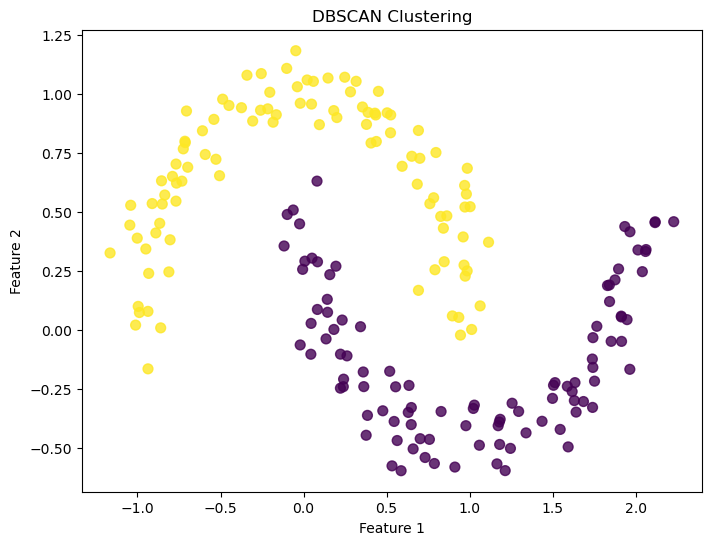

Number of clusters: 2
Number of noise points: 0
Silhouette Score: 0.3214


In [74]:
# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=dbscan_labels, cmap='viridis', s=50, alpha=0.8)
plt.title('DBSCAN Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Print number of clusters found
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')

# Calculate silhouette score (excluding noise points)
mask = dbscan_labels != -1
if len(np.unique(dbscan_labels[mask])) > 1:
    silhouette_avg = silhouette_score(X_moons[mask], dbscan_labels[mask])
    print(f'Silhouette Score: {silhouette_avg:.4f}')

**Lessons:**

- K-means always forces data into spherical clusters centered around centroids
- K-means requires specifying the number of clusters in advance
- DBSCAN can discover clusters of arbitrary shapes based on density
- DBSCAN automatically determines the number of clusters
- DBSCAN identifies outliers as noise rather than forcing them into clusters
- Silhouette score favors convex clusters
